In [1]:
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential, load_model
from keras.layers.core import Dropout, Activation, Flatten, Reshape
from keras.utils import np_utils
from keras.layers import Convolution2D as Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.datasets import mnist
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
import keras

Using TensorFlow backend.


In [6]:
import os
import pickle
import math

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6524034612081800602, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13855477334420762121
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23684893901
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5544137975419573882
 physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:2d:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 23684893901
 locality {
   bus_id: 2
   numa_node: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5715079777642392250
 physical_device_desc: "device: 1, name: TITAN RTX, pci bus id: 0000:99:00.0, compute capability: 7.5", name: "/device:XLA_GPU:0"
 devic

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

W0722 16:06:18.671337 140163054454528 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0722 16:06:18.673747 140163054454528 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0722 16:06:18.675230 140163054454528 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0722 16:06:18.716287 140163054454528 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.g

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [74]:
print('Tensorflow: ', tf.__version__)

Tensorflow:  1.14.0


In [6]:
features_folder = "C:\\Users\\t-anmend\\Documents\\train_1\\"

In [4]:
features_folder = "/home/t-anmend/train1"

In [7]:
with open(os.path.join(features_folder,'train1_features.txt'),'rb') as f:
    features  = pickle.load(f)

In [5]:
with open(os.path.join(features_folder,'train1_stats_features.txt'),'rb') as f:
    features_stats  = pickle.load(f)

In [7]:
features[0]

[array([[153,   8, 164, ...,   0,   5, 255],
        [154,  10, 163, ...,   0,  39, 255],
        [153,   7, 164, ...,   0,   9, 255],
        ...,
        [165,  43, 168, ..., 155, 177, 255],
        [162,  39, 188, ..., 107, 200, 255],
        [164,  38, 176, ..., 209, 153, 255]], dtype=uint8),
 ['drilling', 'dog_bark', 'air_conditioner', 'children_playing', 'jackhammer'],
 'C:\\Users\\t-anmend\\Documents\\train_1\\uniform\\soundscape_train_1_uniform0.wav']

# Features 19x128

In [8]:
np.random.seed(123)

In [9]:
index_features = np.arange(len(features))
    
train_ind = np.random.choice(index_features, int(0.7 * len(index_features)), replace=False)

In [10]:
len(train_ind)

2100

In [35]:
X_train = []
y_train = []
X_test = []
y_test = []

for index in range(len(features)):
    if index in train_ind:
        X_train.append(features[index][0])
        y_train.append(features[index][1])
    else:
        X_test.append(features[index][0])
        y_test.append(features[index][1])

In [36]:
len(X_train)

2100

In [37]:
len(y_train)

2100

In [38]:
len(X_test)

900

In [39]:
len(y_test)

900

In [40]:
X_train = np.array(X_train)

In [41]:
X_test = np.array(X_test)

In [42]:
X_train.shape

(2100, 19, 128)

In [43]:
X_test.shape

(900, 19, 128)

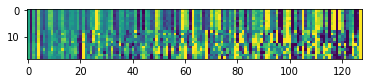

In [44]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

# Build the neural network model

In [45]:
# this is the size of our encoded representations
encoding_dim = 1000  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
#input_img = Input(shape=(np.prod(X_train.shape[1:]),))
input_img = Input(shape=(19,128,1))
# "encoded" is the encoded representation of the input
x = (Flatten(name='flatten'))(input_img)
x = Dense(np.prod(X_train.shape[1:]), activation='relu')(x)
x = Dense(encoding_dim, activation='relu')(x)
#x = Dense(512, activation='relu')(x)

#encoded = Dense(256, activation='relu')(x)

# "decoded" is the lossy reconstruction of the input
encoded = Dense(512, activation='relu')(x)
x = Dense(1000, activation='relu')(encoded)

x = Dense(np.prod(X_train.shape[1:]), activation='relu')(x)
decoded = (Reshape((19,128,1)))(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [46]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 19, 128, 1)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2432)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2432)              5917056   
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              2433000   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              513000    
_________________________________________________________________
dense_10 (Dense)             (None, 2432)              2434432   
__________

In [66]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [67]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(256,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [47]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [34]:
X_train[0]

array([[[153],
        [  8],
        [164],
        ...,
        [  0],
        [  5],
        [255]],

       [[154],
        [ 10],
        [163],
        ...,
        [  0],
        [ 39],
        [255]],

       [[153],
        [  7],
        [164],
        ...,
        [  0],
        [  9],
        [255]],

       ...,

       [[165],
        [ 43],
        [168],
        ...,
        [155],
        [177],
        [255]],

       [[162],
        [ 39],
        [188],
        ...,
        [107],
        [200],
        [255]],

       [[164],
        [ 38],
        [176],
        ...,
        [209],
        [153],
        [255]]], dtype=uint8)

In [24]:
X_test[0]

array([[154,  11, 165, ..., 255, 200, 255],
       [152,   5, 164, ...,  41,  11, 255],
       [153,   6, 164, ...,   0,  12, 255],
       ...,
       [151,   5, 160, ...,   0,   0, 255],
       [152,   8, 164, ...,   0,   0, 255],
       [152,   6, 164, ...,   0,  28, 255]], dtype=uint8)

In [48]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

In [49]:
X_train.shape

(2100, 19, 128, 1)

In [50]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [51]:
X_test.shape

(900, 19, 128, 1)

In [28]:
import time
from datetime import datetime


In [41]:
today = datetime.today()

t = today.strftime("%Y%m%d_%H%M%S")

model_folder = f"C:\\Users\\t-anmend\\Documents\\train_1\\models\\best_model_CNN_{t}.ckpt"
model_folder

'C:\\Users\\t-anmend\\Documents\\train_1\\models\\best_model_CNN_20190718_133049.ckpt'

In [52]:
today = datetime.today()

t = today.strftime("%Y%m%d_%H%M%S")

model_folder = f"/home/t-anmend/train1/models/best_model_CNN_{t}.ckpt"
model_folder

'/home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt'

In [53]:
checkpoint = ModelCheckpoint(model_folder, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [54]:
tensorboard = TensorBoard(log_dir=f"/home/t-anmend/train1/tensor_board/{t}")

In [55]:
rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-7)

In [56]:
autoencoder.fit(X_train, X_train,
                epochs=3000,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpoint, tensorboard, rate])

Train on 2100 samples, validate on 900 samples
Epoch 1/3000
2100/2100 [==============================] - 0s 187us/step - loss: 335254.9701 - val_loss: 21488.3222

Epoch 00001: val_loss improved from inf to 21488.32220, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2/3000
2100/2100 [==============================] - 0s 75us/step - loss: 17758.9076 - val_loss: 10317.7157

Epoch 00002: val_loss improved from 21488.32220 to 10317.71567, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 3/3000
2100/2100 [==============================] - 0s 69us/step - loss: 15353.8268 - val_loss: 10261.2315

Epoch 00003: val_loss improved from 10317.71567 to 10261.23146, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 4/3000
2100/2100 [==============================] - 0s 77us/step - loss: 9140.6820 - val_loss: 11563.6918

Epoch 00004: val_loss did not improve from 10261.23146
Epoch 5/3000
2

Epoch 38/3000
2100/2100 [==============================] - 0s 76us/step - loss: 6135.2885 - val_loss: 6055.3335

Epoch 00038: val_loss improved from 6148.65956 to 6055.33345, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 39/3000
2100/2100 [==============================] - 0s 74us/step - loss: 6096.0611 - val_loss: 6038.6917

Epoch 00039: val_loss improved from 6055.33345 to 6038.69166, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 40/3000
2100/2100 [==============================] - 0s 70us/step - loss: 6052.0866 - val_loss: 6023.7616

Epoch 00040: val_loss improved from 6038.69166 to 6023.76160, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 41/3000
2100/2100 [==============================] - 0s 69us/step - loss: 6020.3954 - val_loss: 6019.3864

Epoch 00041: val_loss improved from 6023.76160 to 6019.38641, saving model to /home/t-anmend/train1/models/best_model_C

Epoch 74/3000
2100/2100 [==============================] - 0s 70us/step - loss: 4693.6187 - val_loss: 4783.5673

Epoch 00074: val_loss did not improve from 4721.60623
Epoch 75/3000
2100/2100 [==============================] - 0s 75us/step - loss: 4713.9900 - val_loss: 4690.1890

Epoch 00075: val_loss improved from 4721.60623 to 4690.18903, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 76/3000
2100/2100 [==============================] - 0s 70us/step - loss: 4666.7766 - val_loss: 4702.7531

Epoch 00076: val_loss did not improve from 4690.18903
Epoch 77/3000
2100/2100 [==============================] - 0s 74us/step - loss: 4636.9074 - val_loss: 4604.7728

Epoch 00077: val_loss improved from 4690.18903 to 4604.77280, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 78/3000
2100/2100 [==============================] - 0s 69us/step - loss: 4573.4252 - val_loss: 4653.4765

Epoch 00078: val_loss did not improve fro

2100/2100 [==============================] - 0s 75us/step - loss: 3801.9502 - val_loss: 3804.0742

Epoch 00113: val_loss improved from 3893.49328 to 3804.07416, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 114/3000
2100/2100 [==============================] - 0s 73us/step - loss: 3761.0899 - val_loss: 3892.2849

Epoch 00114: val_loss did not improve from 3804.07416
Epoch 115/3000
2100/2100 [==============================] - 0s 74us/step - loss: 3735.4987 - val_loss: 3802.1502

Epoch 00115: val_loss improved from 3804.07416 to 3802.15017, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 116/3000
2100/2100 [==============================] - 0s 69us/step - loss: 3741.8789 - val_loss: 3835.2648

Epoch 00116: val_loss did not improve from 3802.15017
Epoch 117/3000
2100/2100 [==============================] - 0s 70us/step - loss: 3669.7934 - val_loss: 3790.4176

Epoch 00117: val_loss improved from 3802.15017 to 3

2100/2100 [==============================] - 0s 74us/step - loss: 3272.5887 - val_loss: 3429.5381

Epoch 00153: val_loss improved from 3436.90296 to 3429.53807, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 154/3000
2100/2100 [==============================] - 0s 67us/step - loss: 3265.1064 - val_loss: 3461.6257

Epoch 00154: val_loss did not improve from 3429.53807
Epoch 155/3000
2100/2100 [==============================] - 0s 74us/step - loss: 3257.5858 - val_loss: 3400.2059

Epoch 00155: val_loss improved from 3429.53807 to 3400.20593, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 156/3000
2100/2100 [==============================] - 0s 75us/step - loss: 3240.2431 - val_loss: 3487.9422

Epoch 00156: val_loss did not improve from 3400.20593
Epoch 157/3000
2100/2100 [==============================] - 0s 71us/step - loss: 3234.9703 - val_loss: 3418.8821

Epoch 00157: val_loss did not improve from 3400.205

2100/2100 [==============================] - 0s 69us/step - loss: 2958.9429 - val_loss: 3297.9874

Epoch 00194: val_loss did not improve from 3161.62518
Epoch 195/3000
2100/2100 [==============================] - 0s 74us/step - loss: 2968.0257 - val_loss: 3210.8284

Epoch 00195: val_loss did not improve from 3161.62518
Epoch 196/3000
2100/2100 [==============================] - 0s 74us/step - loss: 2952.9984 - val_loss: 3275.5899

Epoch 00196: val_loss did not improve from 3161.62518
Epoch 197/3000
2100/2100 [==============================] - 0s 74us/step - loss: 2942.0921 - val_loss: 3183.4229

Epoch 00197: val_loss did not improve from 3161.62518
Epoch 198/3000
2100/2100 [==============================] - 0s 74us/step - loss: 2926.1536 - val_loss: 3275.2564

Epoch 00198: val_loss did not improve from 3161.62518
Epoch 199/3000
2100/2100 [==============================] - 0s 73us/step - loss: 2946.8990 - val_loss: 3147.4274

Epoch 00199: val_loss improved from 3161.62518 to 3147.42736,

2100/2100 [==============================] - 0s 75us/step - loss: 2690.0888 - val_loss: 2980.4650

Epoch 00237: val_loss improved from 2993.79932 to 2980.46499, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 238/3000
2100/2100 [==============================] - 0s 69us/step - loss: 2651.3382 - val_loss: 3083.0959

Epoch 00238: val_loss did not improve from 2980.46499
Epoch 239/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2669.2941 - val_loss: 2992.6204

Epoch 00239: val_loss did not improve from 2980.46499
Epoch 240/3000
2100/2100 [==============================] - 0s 74us/step - loss: 2668.7489 - val_loss: 3090.0675

Epoch 00240: val_loss did not improve from 2980.46499
Epoch 241/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2641.9710 - val_loss: 2943.8926

Epoch 00241: val_loss improved from 2980.46499 to 2943.89263, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ck


Epoch 00280: val_loss did not improve from 2848.34730
Epoch 281/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2430.8043 - val_loss: 2830.7174

Epoch 00281: val_loss improved from 2848.34730 to 2830.71742, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 282/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2424.2871 - val_loss: 2949.6013

Epoch 00282: val_loss did not improve from 2830.71742
Epoch 283/3000
2100/2100 [==============================] - 0s 71us/step - loss: 2443.6266 - val_loss: 2809.3071

Epoch 00283: val_loss improved from 2830.71742 to 2809.30712, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 284/3000
2100/2100 [==============================] - 0s 69us/step - loss: 2417.2097 - val_loss: 2978.5385

Epoch 00284: val_loss did not improve from 2809.30712
Epoch 285/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2435.7377 - va

Epoch 318/3000
2100/2100 [==============================] - 0s 73us/step - loss: 2153.5637 - val_loss: 2642.2621

Epoch 00318: val_loss did not improve from 2642.17382
Epoch 319/3000
2100/2100 [==============================] - 0s 72us/step - loss: 2152.4451 - val_loss: 2641.2587

Epoch 00319: val_loss improved from 2642.17382 to 2641.25866, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 320/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2151.3482 - val_loss: 2641.4327

Epoch 00320: val_loss did not improve from 2641.25866
Epoch 321/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2150.2677 - val_loss: 2640.0385

Epoch 00321: val_loss improved from 2641.25866 to 2640.03852, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 322/3000
2100/2100 [==============================] - 0s 68us/step - loss: 2149.1410 - val_loss: 2639.6741

Epoch 00322: val_loss improved from 

2100/2100 [==============================] - 0s 76us/step - loss: 2112.5807 - val_loss: 2617.5318

Epoch 00352: val_loss improved from 2618.11833 to 2617.53184, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 353/3000
2100/2100 [==============================] - 0s 75us/step - loss: 2111.6755 - val_loss: 2618.1872

Epoch 00353: val_loss did not improve from 2617.53184
Epoch 354/3000
2100/2100 [==============================] - 0s 71us/step - loss: 2110.5232 - val_loss: 2617.1103

Epoch 00354: val_loss improved from 2617.53184 to 2617.11029, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 355/3000
2100/2100 [==============================] - 0s 68us/step - loss: 2109.5037 - val_loss: 2617.9941

Epoch 00355: val_loss did not improve from 2617.11029
Epoch 356/3000
2100/2100 [==============================] - 0s 73us/step - loss: 2108.9557 - val_loss: 2616.1722

Epoch 00356: val_loss improved from 2617.11029 to 2


Epoch 00388: val_loss did not improve from 2601.21926
Epoch 389/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2078.2119 - val_loss: 2601.5644

Epoch 00389: val_loss did not improve from 2601.21926
Epoch 390/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2077.3591 - val_loss: 2600.3061

Epoch 00390: val_loss improved from 2601.21926 to 2600.30613, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 391/3000
2100/2100 [==============================] - 0s 73us/step - loss: 2076.5992 - val_loss: 2601.5767

Epoch 00391: val_loss did not improve from 2600.30613
Epoch 392/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2075.5589 - val_loss: 2601.1438

Epoch 00392: val_loss did not improve from 2600.30613
Epoch 393/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2074.9277 - val_loss: 2600.7829

Epoch 00393: val_loss did not improve from 2600.30613
Epoch 394/3000
2

Epoch 427/3000
2100/2100 [==============================] - 0s 72us/step - loss: 2047.1284 - val_loss: 2586.9794

Epoch 00427: val_loss improved from 2587.69120 to 2586.97936, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 428/3000
2100/2100 [==============================] - 0s 66us/step - loss: 2046.3955 - val_loss: 2587.1085

Epoch 00428: val_loss did not improve from 2586.97936
Epoch 429/3000
2100/2100 [==============================] - 0s 71us/step - loss: 2045.6507 - val_loss: 2588.0811

Epoch 00429: val_loss did not improve from 2586.97936
Epoch 430/3000
2100/2100 [==============================] - 0s 71us/step - loss: 2044.3380 - val_loss: 2585.2631

Epoch 00430: val_loss improved from 2586.97936 to 2585.26310, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 431/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2043.6946 - val_loss: 2585.6033

Epoch 00431: val_loss did not improv

2100/2100 [==============================] - 0s 70us/step - loss: 2017.1256 - val_loss: 2574.2641

Epoch 00466: val_loss improved from 2574.26543 to 2574.26415, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 467/3000
2100/2100 [==============================] - 0s 70us/step - loss: 2016.3736 - val_loss: 2572.9484

Epoch 00467: val_loss improved from 2574.26415 to 2572.94845, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 468/3000
2100/2100 [==============================] - 0s 69us/step - loss: 2014.6002 - val_loss: 2572.2288

Epoch 00468: val_loss improved from 2572.94845 to 2572.22881, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 469/3000
2100/2100 [==============================] - 0s 75us/step - loss: 2014.3430 - val_loss: 2573.0971

Epoch 00469: val_loss did not improve from 2572.22881
Epoch 470/3000
2100/2100 [==============================] - 0s 72us/step - l

Epoch 505/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1986.3884 - val_loss: 2560.6197

Epoch 00505: val_loss did not improve from 2559.40643
Epoch 506/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1986.2270 - val_loss: 2559.6423

Epoch 00506: val_loss did not improve from 2559.40643
Epoch 507/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1985.4953 - val_loss: 2558.3662

Epoch 00507: val_loss improved from 2559.40643 to 2558.36619, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 508/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1983.8173 - val_loss: 2558.5768

Epoch 00508: val_loss did not improve from 2558.36619
Epoch 509/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1983.4099 - val_loss: 2557.3955

Epoch 00509: val_loss improved from 2558.36619 to 2557.39548, saving model to /home/t-anmend/train1/models/best_model_CNN_201

2100/2100 [==============================] - 0s 67us/step - loss: 1959.7758 - val_loss: 2549.5258

Epoch 00544: val_loss did not improve from 2548.79425
Epoch 545/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1959.2264 - val_loss: 2547.6761

Epoch 00545: val_loss improved from 2548.79425 to 2547.67609, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 546/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1958.3468 - val_loss: 2549.1485

Epoch 00546: val_loss did not improve from 2547.67609
Epoch 547/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1957.9385 - val_loss: 2547.9090

Epoch 00547: val_loss did not improve from 2547.67609
Epoch 548/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1956.9119 - val_loss: 2548.1682

Epoch 00548: val_loss did not improve from 2547.67609
Epoch 549/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1956.

Epoch 582/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1929.3468 - val_loss: 2534.0154

Epoch 00582: val_loss did not improve from 2533.79507
Epoch 583/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1928.8302 - val_loss: 2533.0747

Epoch 00583: val_loss improved from 2533.79507 to 2533.07468, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 584/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1928.2825 - val_loss: 2534.9845

Epoch 00584: val_loss did not improve from 2533.07468
Epoch 585/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1927.9053 - val_loss: 2533.6303

Epoch 00585: val_loss did not improve from 2533.07468
Epoch 586/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1927.0675 - val_loss: 2532.7071

Epoch 00586: val_loss improved from 2533.07468 to 2532.70709, saving model to /home/t-anmend/train1/models/best_model_CNN_201

Epoch 622/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1904.4467 - val_loss: 2526.0649

Epoch 00622: val_loss did not improve from 2523.15909
Epoch 623/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1904.6258 - val_loss: 2522.9367

Epoch 00623: val_loss improved from 2523.15909 to 2522.93675, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 624/3000
2100/2100 [==============================] - 0s 66us/step - loss: 1903.3847 - val_loss: 2525.0852

Epoch 00624: val_loss did not improve from 2522.93675
Epoch 625/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1902.0921 - val_loss: 2522.1721

Epoch 00625: val_loss improved from 2522.93675 to 2522.17206, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 626/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1902.0346 - val_loss: 2523.2244

Epoch 00626: val_loss did not improv

Epoch 662/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1877.3034 - val_loss: 2511.3462

Epoch 00662: val_loss improved from 2511.37676 to 2511.34616, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 663/3000
2100/2100 [==============================] - 0s 78us/step - loss: 1877.2220 - val_loss: 2511.2634

Epoch 00663: val_loss improved from 2511.34616 to 2511.26340, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 664/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1877.1370 - val_loss: 2511.3079

Epoch 00664: val_loss did not improve from 2511.26340
Epoch 665/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1877.0583 - val_loss: 2511.2767

Epoch 00665: val_loss did not improve from 2511.26340
Epoch 666/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1876.9815 - val_loss: 2511.1949

Epoch 00666: val_loss improved from 

2100/2100 [==============================] - 0s 70us/step - loss: 1874.6201 - val_loss: 2510.3580

Epoch 00698: val_loss improved from 2510.42669 to 2510.35798, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 699/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1874.5380 - val_loss: 2510.2516

Epoch 00699: val_loss improved from 2510.35798 to 2510.25165, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 700/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1874.4661 - val_loss: 2510.2592

Epoch 00700: val_loss did not improve from 2510.25165
Epoch 701/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1874.3921 - val_loss: 2510.2567

Epoch 00701: val_loss did not improve from 2510.25165
Epoch 702/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1874.3124 - val_loss: 2510.3319

Epoch 00702: val_loss did not improve from 2510.251

2100/2100 [==============================] - 0s 71us/step - loss: 1871.7335 - val_loss: 2509.2370

Epoch 00736: val_loss did not improve from 2509.19271
Epoch 737/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1871.6604 - val_loss: 2509.1611

Epoch 00737: val_loss improved from 2509.19271 to 2509.16112, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 738/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1871.5853 - val_loss: 2509.1280

Epoch 00738: val_loss improved from 2509.16112 to 2509.12798, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 739/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1871.5047 - val_loss: 2509.0135

Epoch 00739: val_loss improved from 2509.12798 to 2509.01350, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 740/3000
2100/2100 [==============================] - 0s 68us/step - l

2100/2100 [==============================] - 0s 72us/step - loss: 1868.8668 - val_loss: 2508.1633

Epoch 00774: val_loss did not improve from 2508.10457
Epoch 775/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1868.7893 - val_loss: 2508.1118

Epoch 00775: val_loss did not improve from 2508.10457
Epoch 776/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1868.7140 - val_loss: 2508.0389

Epoch 00776: val_loss improved from 2508.10457 to 2508.03887, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 777/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1868.6356 - val_loss: 2508.1172

Epoch 00777: val_loss did not improve from 2508.03887
Epoch 778/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1868.5590 - val_loss: 2508.0211

Epoch 00778: val_loss improved from 2508.03887 to 2508.02110, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ck

2100/2100 [==============================] - 0s 71us/step - loss: 1866.0246 - val_loss: 2506.9469

Epoch 00812: val_loss improved from 2507.06373 to 2506.94695, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 813/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1865.9498 - val_loss: 2507.0123

Epoch 00813: val_loss did not improve from 2506.94695
Epoch 814/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1865.8738 - val_loss: 2507.0663

Epoch 00814: val_loss did not improve from 2506.94695
Epoch 815/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1865.7977 - val_loss: 2507.0044

Epoch 00815: val_loss did not improve from 2506.94695
Epoch 816/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1865.7275 - val_loss: 2507.0552

Epoch 00816: val_loss did not improve from 2506.94695
Epoch 817/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1865.

Epoch 853/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1862.9653 - val_loss: 2505.9615

Epoch 00853: val_loss improved from 2505.96919 to 2505.96146, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 854/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1862.8952 - val_loss: 2505.9187

Epoch 00854: val_loss improved from 2505.96146 to 2505.91871, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 855/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1862.8210 - val_loss: 2505.8284

Epoch 00855: val_loss improved from 2505.91871 to 2505.82835, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 856/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1862.7488 - val_loss: 2505.8155

Epoch 00856: val_loss improved from 2505.82835 to 2505.81550, saving model to /home/t-anmend/train1/models/best_mod


Epoch 00890: val_loss did not improve from 2505.03957
Epoch 891/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1860.1639 - val_loss: 2504.9288

Epoch 00891: val_loss improved from 2505.03957 to 2504.92881, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 892/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1860.0990 - val_loss: 2504.8723

Epoch 00892: val_loss improved from 2504.92881 to 2504.87227, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 893/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1860.0198 - val_loss: 2504.8690

Epoch 00893: val_loss improved from 2504.87227 to 2504.86903, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 894/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1859.9505 - val_loss: 2504.8016

Epoch 00894: val_loss improved from 2504.86903 to 2504.80158

Epoch 929/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1857.3852 - val_loss: 2503.9834

Epoch 00929: val_loss did not improve from 2503.95302
Epoch 930/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1857.3155 - val_loss: 2503.9143

Epoch 00930: val_loss improved from 2503.95302 to 2503.91427, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 931/3000
2100/2100 [==============================] - 0s 66us/step - loss: 1857.2451 - val_loss: 2503.9031

Epoch 00931: val_loss improved from 2503.91427 to 2503.90314, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 932/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1857.1657 - val_loss: 2503.8782

Epoch 00932: val_loss improved from 2503.90314 to 2503.87818, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 933/3000
2100/2100 [==============================] - 0

2100/2100 [==============================] - 0s 69us/step - loss: 1854.5439 - val_loss: 2502.9334

Epoch 00968: val_loss improved from 2502.96038 to 2502.93338, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 969/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1854.4741 - val_loss: 2502.8886

Epoch 00969: val_loss improved from 2502.93338 to 2502.88859, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 970/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1854.4068 - val_loss: 2502.8990

Epoch 00970: val_loss did not improve from 2502.88859
Epoch 971/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1854.3340 - val_loss: 2502.8256

Epoch 00971: val_loss improved from 2502.88859 to 2502.82564, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 972/3000
2100/2100 [==============================] - 0s 68us/step - l

2100/2100 [==============================] - 0s 70us/step - loss: 1851.7229 - val_loss: 2501.9001

Epoch 01007: val_loss improved from 2501.96129 to 2501.90008, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1008/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1851.6496 - val_loss: 2501.8647

Epoch 01008: val_loss improved from 2501.90008 to 2501.86469, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1009/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1851.5845 - val_loss: 2501.9696

Epoch 01009: val_loss did not improve from 2501.86469
Epoch 1010/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1851.5103 - val_loss: 2501.7981

Epoch 01010: val_loss improved from 2501.86469 to 2501.79812, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1011/3000
2100/2100 [==============================] - 0s 68us/step


Epoch 01045: val_loss did not improve from 2500.83041
Epoch 1046/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1848.9173 - val_loss: 2500.8413

Epoch 01046: val_loss did not improve from 2500.83041
Epoch 1047/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1848.8459 - val_loss: 2500.8301

Epoch 01047: val_loss improved from 2500.83041 to 2500.83010, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1048/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1848.7680 - val_loss: 2500.7307

Epoch 01048: val_loss improved from 2500.83010 to 2500.73071, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1049/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1848.6929 - val_loss: 2500.6969

Epoch 01049: val_loss improved from 2500.73071 to 2500.69692, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Ep

2100/2100 [==============================] - 0s 76us/step - loss: 1846.2641 - val_loss: 2499.9305

Epoch 01083: val_loss did not improve from 2499.85758
Epoch 1084/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1846.1957 - val_loss: 2499.8399

Epoch 01084: val_loss improved from 2499.85758 to 2499.83990, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1085/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1846.1172 - val_loss: 2499.8894

Epoch 01085: val_loss did not improve from 2499.83990
Epoch 1086/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1846.0462 - val_loss: 2499.9097

Epoch 01086: val_loss did not improve from 2499.83990
Epoch 1087/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1845.9772 - val_loss: 2499.8560

Epoch 01087: val_loss did not improve from 2499.83990
Epoch 1088/3000
2100/2100 [==============================] - 0s 70us/step - loss: 

Epoch 1125/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1843.2648 - val_loss: 2498.8492

Epoch 01125: val_loss improved from 2498.86615 to 2498.84919, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1126/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1843.1956 - val_loss: 2498.8145

Epoch 01126: val_loss improved from 2498.84919 to 2498.81446, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1127/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1843.1212 - val_loss: 2498.7739

Epoch 01127: val_loss improved from 2498.81446 to 2498.77386, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1128/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1843.0554 - val_loss: 2498.7341

Epoch 01128: val_loss improved from 2498.77386 to 2498.73414, saving model to /home/t-anmend/train1/models/best

2100/2100 [==============================] - 0s 70us/step - loss: 1840.4922 - val_loss: 2497.8616

Epoch 01164: val_loss did not improve from 2497.79847
Epoch 1165/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1840.4220 - val_loss: 2497.8647

Epoch 01165: val_loss did not improve from 2497.79847
Epoch 1166/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1840.3504 - val_loss: 2497.7772

Epoch 01166: val_loss improved from 2497.79847 to 2497.77721, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1167/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1840.2741 - val_loss: 2497.7326

Epoch 01167: val_loss improved from 2497.77721 to 2497.73259, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1168/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1840.2101 - val_loss: 2497.7602

Epoch 01168: val_loss did not improve from 2497


Epoch 01204: val_loss improved from 2496.85054 to 2496.83914, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1205/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1837.6000 - val_loss: 2496.8328

Epoch 01205: val_loss improved from 2496.83914 to 2496.83279, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1206/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1837.5257 - val_loss: 2496.8051

Epoch 01206: val_loss improved from 2496.83279 to 2496.80509, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1207/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1837.4520 - val_loss: 2496.7399

Epoch 01207: val_loss improved from 2496.80509 to 2496.73988, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1208/3000
2100/2100 [==============================] - 0s 70us/step - loss: 

2100/2100 [==============================] - 0s 70us/step - loss: 1834.7795 - val_loss: 2495.8711

Epoch 01245: val_loss did not improve from 2495.79258
Epoch 1246/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1834.7143 - val_loss: 2495.7945

Epoch 01246: val_loss did not improve from 2495.79258
Epoch 1247/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1834.6461 - val_loss: 2495.7051

Epoch 01247: val_loss improved from 2495.79258 to 2495.70509, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1248/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1834.5732 - val_loss: 2495.6861

Epoch 01248: val_loss improved from 2495.70509 to 2495.68611, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1249/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1834.5044 - val_loss: 2495.7407

Epoch 01249: val_loss did not improve from 2495

Epoch 1285/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1831.9769 - val_loss: 2494.8335

Epoch 01285: val_loss did not improve from 2494.68254
Epoch 1286/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1831.9007 - val_loss: 2494.8268

Epoch 01286: val_loss did not improve from 2494.68254
Epoch 1287/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1831.8314 - val_loss: 2494.7259

Epoch 01287: val_loss did not improve from 2494.68254
Epoch 1288/3000
2100/2100 [==============================] - 0s 76us/step - loss: 1831.7645 - val_loss: 2494.7455

Epoch 01288: val_loss did not improve from 2494.68254
Epoch 1289/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1831.6953 - val_loss: 2494.7887

Epoch 01289: val_loss did not improve from 2494.68254
Epoch 1290/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1831.6237 - val_loss: 2494.8402

Epoch 01290: val_loss did not improve fr

Epoch 1326/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1829.1154 - val_loss: 2493.7178

Epoch 01326: val_loss improved from 2493.76151 to 2493.71782, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1327/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1829.0390 - val_loss: 2493.7840

Epoch 01327: val_loss did not improve from 2493.71782
Epoch 1328/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1828.9748 - val_loss: 2493.6960

Epoch 01328: val_loss improved from 2493.71782 to 2493.69605, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1329/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1828.9077 - val_loss: 2493.7333

Epoch 01329: val_loss did not improve from 2493.69605
Epoch 1330/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1828.8372 - val_loss: 2493.5921

Epoch 01330: val_loss improved 

Epoch 1366/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1826.3272 - val_loss: 2492.8504

Epoch 01366: val_loss improved from 2492.90768 to 2492.85043, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1367/3000
2100/2100 [==============================] - 0s 66us/step - loss: 1826.2620 - val_loss: 2492.8273

Epoch 01367: val_loss improved from 2492.85043 to 2492.82729, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1368/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1826.1924 - val_loss: 2492.8152

Epoch 01368: val_loss improved from 2492.82729 to 2492.81519, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1369/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1826.1155 - val_loss: 2492.8256

Epoch 01369: val_loss did not improve from 2492.81519
Epoch 1370/3000
2100/2100 [==============================

2100/2100 [==============================] - 0s 71us/step - loss: 1823.7682 - val_loss: 2491.9727

Epoch 01403: val_loss improved from 2492.03590 to 2491.97271, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1404/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1823.6933 - val_loss: 2491.9733

Epoch 01404: val_loss did not improve from 2491.97271
Epoch 1405/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1823.6254 - val_loss: 2491.9521

Epoch 01405: val_loss improved from 2491.97271 to 2491.95212, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1406/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1823.5581 - val_loss: 2491.8264

Epoch 01406: val_loss improved from 2491.95212 to 2491.82642, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1407/3000
2100/2100 [==============================] - 0s 68us/step

Epoch 1442/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1821.0703 - val_loss: 2491.0712

Epoch 01442: val_loss did not improve from 2491.05885
Epoch 1443/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1821.0018 - val_loss: 2491.1729

Epoch 01443: val_loss did not improve from 2491.05885
Epoch 1444/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1820.9343 - val_loss: 2491.0441

Epoch 01444: val_loss improved from 2491.05885 to 2491.04412, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1445/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1820.8599 - val_loss: 2491.0348

Epoch 01445: val_loss improved from 2491.04412 to 2491.03479, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1446/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1820.7928 - val_loss: 2491.0470

Epoch 01446: val_loss did not i

Epoch 1479/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1818.5280 - val_loss: 2490.1692

Epoch 01479: val_loss improved from 2490.20232 to 2490.16917, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1480/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1818.4586 - val_loss: 2490.1096

Epoch 01480: val_loss improved from 2490.16917 to 2490.10956, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1481/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1818.3898 - val_loss: 2490.1395

Epoch 01481: val_loss did not improve from 2490.10956
Epoch 1482/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1818.3222 - val_loss: 2490.0500

Epoch 01482: val_loss improved from 2490.10956 to 2490.05004, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1483/3000
2100/2100 [==============================

Epoch 1517/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1815.9144 - val_loss: 2489.2858

Epoch 01517: val_loss did not improve from 2489.26449
Epoch 1518/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1815.8513 - val_loss: 2489.2502

Epoch 01518: val_loss improved from 2489.26449 to 2489.25025, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1519/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1815.7858 - val_loss: 2489.2310

Epoch 01519: val_loss improved from 2489.25025 to 2489.23100, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1520/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1815.7170 - val_loss: 2489.2142

Epoch 01520: val_loss improved from 2489.23100 to 2489.21422, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1521/3000
2100/2100 [==============================

Epoch 1556/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1813.2616 - val_loss: 2488.2501

Epoch 01556: val_loss improved from 2488.33664 to 2488.25013, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1557/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1813.1989 - val_loss: 2488.3304

Epoch 01557: val_loss did not improve from 2488.25013
Epoch 1558/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1813.1236 - val_loss: 2488.2464

Epoch 01558: val_loss improved from 2488.25013 to 2488.24636, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1559/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1813.0520 - val_loss: 2488.2216

Epoch 01559: val_loss improved from 2488.24636 to 2488.22164, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1560/3000
2100/2100 [==============================

2100/2100 [==============================] - 0s 70us/step - loss: 1810.4761 - val_loss: 2487.3098

Epoch 01597: val_loss improved from 2487.36018 to 2487.30979, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1598/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1810.4052 - val_loss: 2487.2939

Epoch 01598: val_loss improved from 2487.30979 to 2487.29387, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1599/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1810.3413 - val_loss: 2487.3744

Epoch 01599: val_loss did not improve from 2487.29387
Epoch 1600/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1810.2744 - val_loss: 2487.3359

Epoch 01600: val_loss did not improve from 2487.29387
Epoch 1601/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1810.2063 - val_loss: 2487.3547

Epoch 01601: val_loss did not improve from 2487

Epoch 1638/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1807.6870 - val_loss: 2486.5284

Epoch 01638: val_loss did not improve from 2486.47668
Epoch 1639/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1807.6203 - val_loss: 2486.3874

Epoch 01639: val_loss improved from 2486.47668 to 2486.38739, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1640/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1807.5549 - val_loss: 2486.4155

Epoch 01640: val_loss did not improve from 2486.38739
Epoch 1641/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1807.4875 - val_loss: 2486.3618

Epoch 01641: val_loss improved from 2486.38739 to 2486.36184, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1642/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1807.4187 - val_loss: 2486.2421

Epoch 01642: val_loss improved 

2100/2100 [==============================] - 0s 73us/step - loss: 1805.0904 - val_loss: 2485.5350

Epoch 01676: val_loss did not improve from 2485.49887
Epoch 1677/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1805.0134 - val_loss: 2485.5675

Epoch 01677: val_loss did not improve from 2485.49887
Epoch 1678/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1804.9473 - val_loss: 2485.4248

Epoch 01678: val_loss improved from 2485.49887 to 2485.42477, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1679/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1804.8792 - val_loss: 2485.3961

Epoch 01679: val_loss improved from 2485.42477 to 2485.39611, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1680/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1804.7986 - val_loss: 2485.4631

Epoch 01680: val_loss did not improve from 2485

2100/2100 [==============================] - 0s 72us/step - loss: 1796.7356 - val_loss: 2478.3363

Epoch 01711: val_loss improved from 2478.51927 to 2478.33632, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1712/3000
2100/2100 [==============================] - 0s 76us/step - loss: 1796.6099 - val_loss: 2478.1019

Epoch 01712: val_loss improved from 2478.33632 to 2478.10188, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1713/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1796.4974 - val_loss: 2478.2258

Epoch 01713: val_loss did not improve from 2478.10188
Epoch 1714/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1796.4026 - val_loss: 2478.1435

Epoch 01714: val_loss did not improve from 2478.10188
Epoch 1715/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1796.3050 - val_loss: 2478.1629

Epoch 01715: val_loss did not improve from 2478

2100/2100 [==============================] - 0s 70us/step - loss: 1793.8184 - val_loss: 2477.1867

Epoch 01749: val_loss did not improve from 2477.15692
Epoch 1750/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1793.7484 - val_loss: 2477.1062

Epoch 01750: val_loss improved from 2477.15692 to 2477.10622, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1751/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1793.6774 - val_loss: 2477.1951

Epoch 01751: val_loss did not improve from 2477.10622
Epoch 1752/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1793.6044 - val_loss: 2477.0802

Epoch 01752: val_loss improved from 2477.10622 to 2477.08025, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1753/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1793.5383 - val_loss: 2477.1372

Epoch 01753: val_loss did not improve from 2477

2100/2100 [==============================] - 0s 71us/step - loss: 1791.1352 - val_loss: 2476.1978

Epoch 01788: val_loss did not improve from 2476.17009
Epoch 1789/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1791.0636 - val_loss: 2476.2246

Epoch 01789: val_loss did not improve from 2476.17009
Epoch 1790/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1790.9957 - val_loss: 2476.1807

Epoch 01790: val_loss did not improve from 2476.17009
Epoch 1791/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1790.9222 - val_loss: 2476.1003

Epoch 01791: val_loss improved from 2476.17009 to 2476.10027, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1792/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1790.8632 - val_loss: 2476.1412

Epoch 01792: val_loss did not improve from 2476.10027
Epoch 1793/3000
2100/2100 [==============================] - 0s 71us/step - loss: 

2100/2100 [==============================] - 0s 70us/step - loss: 1788.4130 - val_loss: 2475.2209

Epoch 01828: val_loss did not improve from 2475.21141
Epoch 1829/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1788.3428 - val_loss: 2475.2219

Epoch 01829: val_loss did not improve from 2475.21141
Epoch 1830/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1788.2750 - val_loss: 2475.1735

Epoch 01830: val_loss improved from 2475.21141 to 2475.17347, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1831/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1788.2072 - val_loss: 2475.2146

Epoch 01831: val_loss did not improve from 2475.17347
Epoch 1832/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1788.1400 - val_loss: 2475.0986

Epoch 01832: val_loss improved from 2475.17347 to 2475.09860, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_16190

2100/2100 [==============================] - 0s 70us/step - loss: 1785.6567 - val_loss: 2474.3241

Epoch 01869: val_loss did not improve from 2474.30709
Epoch 1870/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1785.5881 - val_loss: 2474.2782

Epoch 01870: val_loss improved from 2474.30709 to 2474.27815, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1871/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1785.5219 - val_loss: 2474.2456

Epoch 01871: val_loss improved from 2474.27815 to 2474.24560, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1872/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1785.4537 - val_loss: 2474.2259

Epoch 01872: val_loss improved from 2474.24560 to 2474.22591, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1873/3000
2100/2100 [==============================] - 0s 72us/step


Epoch 01908: val_loss did not improve from 2473.42344
Epoch 1909/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1782.9790 - val_loss: 2473.4216

Epoch 01909: val_loss improved from 2473.42344 to 2473.42160, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1910/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1782.9160 - val_loss: 2473.4325

Epoch 01910: val_loss did not improve from 2473.42160
Epoch 1911/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1782.8481 - val_loss: 2473.2526

Epoch 01911: val_loss improved from 2473.42160 to 2473.25260, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1912/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1782.7794 - val_loss: 2473.3453

Epoch 01912: val_loss did not improve from 2473.25260
Epoch 1913/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1782.7117

Epoch 1949/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1780.3224 - val_loss: 2472.5359

Epoch 01949: val_loss improved from 2472.53921 to 2472.53595, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1950/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1780.2551 - val_loss: 2472.4387

Epoch 01950: val_loss improved from 2472.53595 to 2472.43865, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1951/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1780.1868 - val_loss: 2472.5095

Epoch 01951: val_loss did not improve from 2472.43865
Epoch 1952/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1780.1208 - val_loss: 2472.4302

Epoch 01952: val_loss improved from 2472.43865 to 2472.43024, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1953/3000
2100/2100 [==============================

Epoch 1988/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1777.7287 - val_loss: 2471.7264

Epoch 01988: val_loss did not improve from 2471.62643
Epoch 1989/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1777.6631 - val_loss: 2471.6132

Epoch 01989: val_loss improved from 2471.62643 to 2471.61317, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1990/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1777.5955 - val_loss: 2471.6078

Epoch 01990: val_loss improved from 2471.61317 to 2471.60783, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 1991/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1777.5271 - val_loss: 2471.6380

Epoch 01991: val_loss did not improve from 2471.60783
Epoch 1992/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1777.4639 - val_loss: 2471.7415

Epoch 01992: val_loss did not i

2100/2100 [==============================] - 0s 70us/step - loss: 1775.2751 - val_loss: 2470.7862

Epoch 02025: val_loss improved from 2470.84730 to 2470.78619, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2026/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1775.2105 - val_loss: 2470.8213

Epoch 02026: val_loss did not improve from 2470.78619
Epoch 2027/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1775.1403 - val_loss: 2470.7674

Epoch 02027: val_loss improved from 2470.78619 to 2470.76740, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2028/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1775.0787 - val_loss: 2470.7356

Epoch 02028: val_loss improved from 2470.76740 to 2470.73555, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2029/3000
2100/2100 [==============================] - 0s 69us/step


Epoch 02064: val_loss improved from 2469.86424 to 2469.80771, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2065/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1772.6345 - val_loss: 2470.0127

Epoch 02065: val_loss did not improve from 2469.80771
Epoch 2066/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1772.5756 - val_loss: 2469.9254

Epoch 02066: val_loss did not improve from 2469.80771
Epoch 2067/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1772.5052 - val_loss: 2469.9223

Epoch 02067: val_loss did not improve from 2469.80771
Epoch 2068/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1772.4383 - val_loss: 2469.8296

Epoch 02068: val_loss did not improve from 2469.80771
Epoch 2069/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1772.3732 - val_loss: 2469.9649

Epoch 02069: val_loss did not improve from 2469.80771
Epoch 2070/

2100/2100 [==============================] - 0s 71us/step - loss: 1769.9425 - val_loss: 2468.9591

Epoch 02106: val_loss improved from 2469.10417 to 2468.95913, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2107/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1769.8793 - val_loss: 2469.0785

Epoch 02107: val_loss did not improve from 2468.95913
Epoch 2108/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1769.8163 - val_loss: 2469.0785

Epoch 02108: val_loss did not improve from 2468.95913
Epoch 2109/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1769.7484 - val_loss: 2468.9946

Epoch 02109: val_loss did not improve from 2468.95913
Epoch 2110/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1769.6788 - val_loss: 2469.0930

Epoch 02110: val_loss did not improve from 2468.95913
Epoch 2111/3000
2100/2100 [==============================] - 0s 70us/step - loss: 


Epoch 02146: val_loss improved from 2468.27519 to 2468.15207, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2147/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1767.2694 - val_loss: 2468.1979

Epoch 02147: val_loss did not improve from 2468.15207
Epoch 2148/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1767.1977 - val_loss: 2468.1759

Epoch 02148: val_loss did not improve from 2468.15207
Epoch 2149/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1767.1336 - val_loss: 2468.1281

Epoch 02149: val_loss improved from 2468.15207 to 2468.12814, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2150/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1767.0735 - val_loss: 2468.1909

Epoch 02150: val_loss did not improve from 2468.12814
Epoch 2151/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1767.0090


Epoch 02185: val_loss did not improve from 2467.45105
Epoch 2186/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1764.7373 - val_loss: 2467.5418

Epoch 02186: val_loss did not improve from 2467.45105
Epoch 2187/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1764.6713 - val_loss: 2467.3332

Epoch 02187: val_loss improved from 2467.45105 to 2467.33324, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2188/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1764.6101 - val_loss: 2467.3211

Epoch 02188: val_loss improved from 2467.33324 to 2467.32113, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2189/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1764.5447 - val_loss: 2467.3895

Epoch 02189: val_loss did not improve from 2467.32113
Epoch 2190/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1764.4786

2100/2100 [==============================] - 0s 71us/step - loss: 1762.2807 - val_loss: 2466.6909

Epoch 02224: val_loss did not improve from 2466.54813
Epoch 2225/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1762.2173 - val_loss: 2466.6674

Epoch 02225: val_loss did not improve from 2466.54813
Epoch 2226/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1762.1500 - val_loss: 2466.7475

Epoch 02226: val_loss did not improve from 2466.54813
Epoch 2227/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1762.0813 - val_loss: 2466.5701

Epoch 02227: val_loss did not improve from 2466.54813
Epoch 2228/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1762.0232 - val_loss: 2466.5505

Epoch 02228: val_loss did not improve from 2466.54813
Epoch 2229/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1761.9515 - val_loss: 2466.5421

Epoch 02229: val_loss improved from 2466.54813 to 2466.5


Epoch 02264: val_loss improved from 2465.81450 to 2465.78763, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2265/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1759.6288 - val_loss: 2465.7246

Epoch 02265: val_loss improved from 2465.78763 to 2465.72456, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2266/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1759.5599 - val_loss: 2465.7654

Epoch 02266: val_loss did not improve from 2465.72456
Epoch 2267/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1759.5001 - val_loss: 2465.8347

Epoch 02267: val_loss did not improve from 2465.72456
Epoch 2268/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1759.4359 - val_loss: 2465.7418

Epoch 02268: val_loss did not improve from 2465.72456
Epoch 2269/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1759.3710

Epoch 2305/3000
2100/2100 [==============================] - 0s 76us/step - loss: 1757.0598 - val_loss: 2464.9733

Epoch 02305: val_loss did not improve from 2464.91604
Epoch 2306/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1756.9941 - val_loss: 2464.8945

Epoch 02306: val_loss improved from 2464.91604 to 2464.89450, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2307/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1756.9289 - val_loss: 2464.8982

Epoch 02307: val_loss did not improve from 2464.89450
Epoch 2308/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1756.8585 - val_loss: 2464.8807

Epoch 02308: val_loss improved from 2464.89450 to 2464.88074, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2309/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1756.7998 - val_loss: 2464.8379

Epoch 02309: val_loss improved 

Epoch 2343/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1754.6227 - val_loss: 2464.1087

Epoch 02343: val_loss did not improve from 2464.07040
Epoch 2344/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1754.5582 - val_loss: 2464.1433

Epoch 02344: val_loss did not improve from 2464.07040
Epoch 2345/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1754.4912 - val_loss: 2464.0248

Epoch 02345: val_loss improved from 2464.07040 to 2464.02478, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2346/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1754.4335 - val_loss: 2464.1503

Epoch 02346: val_loss did not improve from 2464.02478
Epoch 2347/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1754.3617 - val_loss: 2464.1575

Epoch 02347: val_loss did not improve from 2464.02478
Epoch 2348/3000
2100/2100 [==============================] - 0s 70


Epoch 02384: val_loss improved from 2463.34401 to 2463.27048, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2385/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1751.9399 - val_loss: 2463.3362

Epoch 02385: val_loss did not improve from 2463.27048
Epoch 2386/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1751.8767 - val_loss: 2463.2259

Epoch 02386: val_loss improved from 2463.27048 to 2463.22590, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2387/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1751.8152 - val_loss: 2463.2037

Epoch 02387: val_loss improved from 2463.22590 to 2463.20368, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2388/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1751.7471 - val_loss: 2463.1379

Epoch 02388: val_loss improved from 2463.20368 to 2463.1

2100/2100 [==============================] - 0s 73us/step - loss: 1749.3292 - val_loss: 2462.4759

Epoch 02426: val_loss improved from 2462.54293 to 2462.47593, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2427/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1749.2653 - val_loss: 2462.5653

Epoch 02427: val_loss did not improve from 2462.47593
Epoch 2428/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1749.2016 - val_loss: 2462.3655

Epoch 02428: val_loss improved from 2462.47593 to 2462.36550, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2429/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1749.1366 - val_loss: 2462.4288

Epoch 02429: val_loss did not improve from 2462.36550
Epoch 2430/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1749.0702 - val_loss: 2462.3798

Epoch 02430: val_loss did not improve from 2462

Epoch 2467/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1746.7213 - val_loss: 2461.6523

Epoch 02467: val_loss improved from 2461.70868 to 2461.65227, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2468/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1746.6592 - val_loss: 2461.7452

Epoch 02468: val_loss did not improve from 2461.65227
Epoch 2469/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1746.5969 - val_loss: 2461.5877

Epoch 02469: val_loss improved from 2461.65227 to 2461.58775, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2470/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1746.5321 - val_loss: 2461.6605

Epoch 02470: val_loss did not improve from 2461.58775
Epoch 2471/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1746.4737 - val_loss: 2461.6447

Epoch 02471: val_loss did not i


Epoch 02508: val_loss did not improve from 2460.71561
Epoch 2509/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1744.0564 - val_loss: 2460.8807

Epoch 02509: val_loss did not improve from 2460.71561
Epoch 2510/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1743.9896 - val_loss: 2460.8596

Epoch 02510: val_loss did not improve from 2460.71561
Epoch 2511/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1743.9323 - val_loss: 2460.8611

Epoch 02511: val_loss did not improve from 2460.71561
Epoch 2512/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1743.8711 - val_loss: 2460.7476

Epoch 02512: val_loss did not improve from 2460.71561
Epoch 2513/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1743.8006 - val_loss: 2460.7140

Epoch 02513: val_loss improved from 2460.71561 to 2460.71404, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2514/

2100/2100 [==============================] - 0s 71us/step - loss: 1741.4716 - val_loss: 2459.8961

Epoch 02550: val_loss improved from 2460.03154 to 2459.89608, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2551/3000
2100/2100 [==============================] - 0s 75us/step - loss: 1741.4085 - val_loss: 2459.9747

Epoch 02551: val_loss did not improve from 2459.89608
Epoch 2552/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1741.3438 - val_loss: 2459.9723

Epoch 02552: val_loss did not improve from 2459.89608
Epoch 2553/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1741.2852 - val_loss: 2460.0205

Epoch 02553: val_loss did not improve from 2459.89608
Epoch 2554/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1741.2246 - val_loss: 2459.9247

Epoch 02554: val_loss did not improve from 2459.89608
Epoch 2555/3000
2100/2100 [==============================] - 0s 70us/step - loss: 

2100/2100 [==============================] - 0s 69us/step - loss: 1738.8263 - val_loss: 2459.2650

Epoch 02591: val_loss improved from 2459.28181 to 2459.26505, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2592/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1738.8127 - val_loss: 2459.2633

Epoch 02592: val_loss improved from 2459.26505 to 2459.26330, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2593/3000
2100/2100 [==============================] - 0s 66us/step - loss: 1738.8019 - val_loss: 2459.2531

Epoch 02593: val_loss improved from 2459.26330 to 2459.25314, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2594/3000
2100/2100 [==============================] - 0s 66us/step - loss: 1738.7933 - val_loss: 2459.2588

Epoch 02594: val_loss did not improve from 2459.25314
Epoch 2595/3000
2100/2100 [==============================] - 0s 70us/step

2100/2100 [==============================] - 0s 74us/step - loss: 1738.5486 - val_loss: 2459.1839

Epoch 02630: val_loss did not improve from 2459.17522
Epoch 2631/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1738.5425 - val_loss: 2459.1812

Epoch 02631: val_loss did not improve from 2459.17522
Epoch 2632/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1738.5355 - val_loss: 2459.1752

Epoch 02632: val_loss did not improve from 2459.17522
Epoch 2633/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1738.5293 - val_loss: 2459.1747

Epoch 02633: val_loss improved from 2459.17522 to 2459.17472, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2634/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1738.5226 - val_loss: 2459.1625

Epoch 02634: val_loss improved from 2459.17472 to 2459.16250, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_16190


Epoch 02669: val_loss did not improve from 2459.09648
Epoch 2670/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1738.2898 - val_loss: 2459.0992

Epoch 02670: val_loss did not improve from 2459.09648
Epoch 2671/3000
2100/2100 [==============================] - 0s 72us/step - loss: 1738.2832 - val_loss: 2459.1009

Epoch 02671: val_loss did not improve from 2459.09648
Epoch 2672/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1738.2770 - val_loss: 2459.0959

Epoch 02672: val_loss improved from 2459.09648 to 2459.09594, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2673/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1738.2704 - val_loss: 2459.0940

Epoch 02673: val_loss improved from 2459.09594 to 2459.09404, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2674/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1738.2641

2100/2100 [==============================] - 0s 70us/step - loss: 1738.0397 - val_loss: 2459.0183

Epoch 02709: val_loss did not improve from 2459.01804
Epoch 2710/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1738.0333 - val_loss: 2459.0205

Epoch 02710: val_loss did not improve from 2459.01804
Epoch 2711/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1738.0270 - val_loss: 2459.0233

Epoch 02711: val_loss did not improve from 2459.01804
Epoch 2712/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1738.0205 - val_loss: 2459.0184

Epoch 02712: val_loss did not improve from 2459.01804
Epoch 2713/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1738.0142 - val_loss: 2459.0161

Epoch 02713: val_loss improved from 2459.01804 to 2459.01613, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2714/3000
2100/2100 [==============================] - 0s 68us/step - loss: 

Epoch 2750/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1737.7775 - val_loss: 2458.9373

Epoch 02750: val_loss improved from 2458.93842 to 2458.93733, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2751/3000
2100/2100 [==============================] - 0s 74us/step - loss: 1737.7710 - val_loss: 2458.9262

Epoch 02751: val_loss improved from 2458.93733 to 2458.92616, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2752/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1737.7648 - val_loss: 2458.9443

Epoch 02752: val_loss did not improve from 2458.92616
Epoch 2753/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1737.7585 - val_loss: 2458.9448

Epoch 02753: val_loss did not improve from 2458.92616
Epoch 2754/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1737.7520 - val_loss: 2458.9468

Epoch 02754: val_loss did not i


Epoch 02789: val_loss improved from 2458.87598 to 2458.86681, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2790/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1737.5222 - val_loss: 2458.8685

Epoch 02790: val_loss did not improve from 2458.86681
Epoch 2791/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1737.5160 - val_loss: 2458.8663

Epoch 02791: val_loss improved from 2458.86681 to 2458.86627, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2792/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1737.5088 - val_loss: 2458.8647

Epoch 02792: val_loss improved from 2458.86627 to 2458.86474, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2793/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1737.5031 - val_loss: 2458.8645

Epoch 02793: val_loss improved from 2458.86474 to 2458.8

2100/2100 [==============================] - 0s 69us/step - loss: 1737.2863 - val_loss: 2458.8028

Epoch 02827: val_loss did not improve from 2458.79744
Epoch 2828/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1737.2810 - val_loss: 2458.8035

Epoch 02828: val_loss did not improve from 2458.79744
Epoch 2829/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1737.2735 - val_loss: 2458.8021

Epoch 02829: val_loss did not improve from 2458.79744
Epoch 2830/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1737.2677 - val_loss: 2458.8017

Epoch 02830: val_loss did not improve from 2458.79744
Epoch 2831/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1737.2610 - val_loss: 2458.7970

Epoch 02831: val_loss improved from 2458.79744 to 2458.79703, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2832/3000
2100/2100 [==============================] - 0s 68us/step - loss: 

2100/2100 [==============================] - 0s 71us/step - loss: 1737.0456 - val_loss: 2458.7123

Epoch 02865: val_loss improved from 2458.72687 to 2458.71234, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_161903.ckpt
Epoch 2866/3000
2100/2100 [==============================] - 0s 73us/step - loss: 1737.0389 - val_loss: 2458.7180

Epoch 02866: val_loss did not improve from 2458.71234
Epoch 2867/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1737.0328 - val_loss: 2458.7171

Epoch 02867: val_loss did not improve from 2458.71234
Epoch 2868/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1737.0261 - val_loss: 2458.7196

Epoch 02868: val_loss did not improve from 2458.71234
Epoch 2869/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1737.0199 - val_loss: 2458.7222

Epoch 02869: val_loss did not improve from 2458.71234
Epoch 2870/3000
2100/2100 [==============================] - 0s 71us/step - loss: 

Epoch 2906/3000
2100/2100 [==============================] - 0s 67us/step - loss: 1736.7846 - val_loss: 2458.6495

Epoch 02906: val_loss did not improve from 2458.63523
Epoch 2907/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1736.7786 - val_loss: 2458.6525

Epoch 02907: val_loss did not improve from 2458.63523
Epoch 2908/3000
2100/2100 [==============================] - 0s 69us/step - loss: 1736.7719 - val_loss: 2458.6480

Epoch 02908: val_loss did not improve from 2458.63523
Epoch 2909/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1736.7654 - val_loss: 2458.6445

Epoch 02909: val_loss did not improve from 2458.63523
Epoch 2910/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1736.7593 - val_loss: 2458.6444

Epoch 02910: val_loss did not improve from 2458.63523
Epoch 2911/3000
2100/2100 [==============================] - 0s 68us/step - loss: 1736.7528 - val_loss: 2458.6408

Epoch 02911: val_loss did not improve fr

2100/2100 [==============================] - 0s 70us/step - loss: 1736.6914 - val_loss: 2458.6396

Epoch 02953: val_loss did not improve from 2458.63523
Epoch 2954/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1736.6915 - val_loss: 2458.6396

Epoch 02954: val_loss did not improve from 2458.63523
Epoch 2955/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1736.6915 - val_loss: 2458.6396

Epoch 02955: val_loss did not improve from 2458.63523

Epoch 02955: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 2956/3000
2100/2100 [==============================] - 0s 71us/step - loss: 1736.6915 - val_loss: 2458.6395

Epoch 02956: val_loss did not improve from 2458.63523
Epoch 2957/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1736.6915 - val_loss: 2458.6395

Epoch 02957: val_loss did not improve from 2458.63523
Epoch 2958/3000
2100/2100 [==============================] - 0s 70us/step - loss: 1736.6915 - val_loss: 24


Epoch 02999: val_loss did not improve from 2458.63523
Epoch 3000/3000
2100/2100 [==============================] - 0s 86us/step - loss: 1736.6915 - val_loss: 2458.6396

Epoch 03000: val_loss did not improve from 2458.63523


In [80]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [66]:
decoded_imgs = autoencoder.predict(X_train)

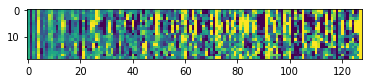

In [77]:
plt.imshow(X_train[100].reshape((19, 128)))

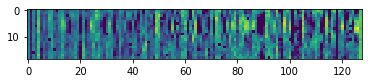

In [76]:
plt.imshow(decoded_imgs[100].reshape((19,128)))

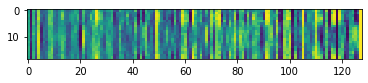

In [81]:
plt.imshow(decoded_imgs[0].reshape((19,128)))

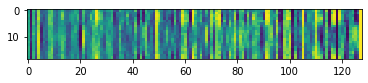

In [83]:
plt.imshow(decoded_imgs[0].reshape((19,128)))

In [ ]:
np.prod(X_train.shape[1:])

# Use the neural network classifier

In [ ]:
model.fit(train_X, train_y_ohe, epochs=100, batch_size=1, verbose=0)

In [ ]:
loss, accuracy = model.evaluate(test_X, test_y_ohe, verbose=0)
print("Accuracy = {:.2f}".format(accuracy))

# PCA

# BUILD CNN

In [206]:
input_shape = (X_train[0].shape[0], X_train[0].shape[1], 1)

In [207]:
input_shape

(19, 128, 1)

In [154]:
input_feature = Input(shape=(input_shape))

x = Conv2D(4, kernel_size=(3,3), activation='relu', input_shape=input_shape, data_format='channels_last', padding='same')(input_feature)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
#x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same', name='pooling')(x)

x = (MaxPooling2D(pool_size=(2,4), padding='same'))(x)
x = (Conv2D(16, (3,3), activation='relu', padding='same'))(x)
x = (MaxPooling2D(pool_size=(2,4), padding='same'))(x)
x = (Conv2D(16, (3,3), activation='relu', padding='same'))(x)
x = (MaxPooling2D(pool_size=(2,2), padding='same', name='pooling'))(x)
encoded = (Conv2D(16, (3,3), activation='relu', padding='same'))(x)
#pooling_shape = tuple(x.shape.as_list()[1:])
#x = (Flatten(name='flatten'))(x)
#x = (Dense(1024, activation='relu'))(x)
#encoded = (Dense(512, activation='relu'))(x)
#x = (Dense(7000, activation='relu'))(x)
#x = (Dense(3500, activation='relu'))(x)
#x = (Dense(1500, activation='relu'))(x)
#encoded = (Dense(512, activation='relu'))(x)
#x = (Dense(1500, activation='relu'))(encoded)
#x = (Dense(3500, activation='relu'))(x)
#x = (Dense(7000, activation='relu'))(x)
#x = (Dense(1024, activation='relu'))(encoded)
#x = (Dense(30000, activation='relu'))(x)

#x = (Dense(np.prod(pooling_shape), activation='relu'))(encoded)
#x = (Reshape((pooling_shape)))(x)

#x = (Conv2D(256, (3,1), activation='relu', padding='same'))(encoded)

x = (UpSampling2D(size=(2,2)))(encoded)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,4)))(x)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,4)))(x)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (Conv2D(8, (3,3), activation='relu',padding='same'))(x)
x = (Conv2D(4, (3,3), activation='relu',padding='same'))(x)
decoded = (Conv2D(1, (3,3), activation='sigmoid',padding='same'))(x)
autoencoder = Model(input_feature, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [165]:
input_feature = Input(shape=(input_shape))

x = Conv2D(4, kernel_size=(9,15), activation='relu', input_shape=input_shape, data_format='channels_last')(input_feature)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(8, (9,15), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(16, (9,15), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
#x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same', name='pooling')(x)

#x = (MaxPooling2D(pool_size=(2,4), padding='same'))(x)
x = (Conv2D(16, (8,15), activation='relu'))(x)
x = (Conv2D(16, (1,15), activation='relu'))(x)
x = (Conv2D(16, (1,15), activation='relu'))(x)
encoded = (Conv2D(16, (1,13), activation='relu'))(x)
#encoded = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (MaxPooling2D(pool_size=(2,4), padding='same', name='pooling'))(x)
#x = (Conv2D(16, (9,15), activation='relu', padding='same'))(x)

#x = (Conv2D(16, (9,30), activation='relu', padding='same'))(x)


#pooling_shape = tuple(x.shape.as_list()[1:])
#x = (Flatten(name='flatten'))(x)
#x = (Dense(1024, activation='relu'))(x)
#encoded = (Dense(512, activation='relu'))(x)
#x = (Dense(7000, activation='relu'))(x)
#x = (Dense(3500, activation='relu'))(x)
#x = (Dense(1500, activation='relu'))(x)
#encoded = (Dense(512, activation='relu'))(x)
#x = (Dense(1500, activation='relu'))(encoded)
#x = (Dense(3500, activation='relu'))(x)
#x = (Dense(7000, activation='relu'))(x)
#x = (Dense(1024, activation='relu'))(encoded)
#x = (Dense(30000, activation='relu'))(x)

#x = (Dense(np.prod(pooling_shape), activation='relu'))(encoded)
#x = (Reshape((pooling_shape)))(x)

#x = (Conv2D(256, (3,1), activation='relu', padding='same'))(encoded)

x = (UpSampling2D(size=(2,2)))(encoded)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,2)))(x)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,1)))(x)
x = (Conv2D(8, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,1)))(x)
x = (Conv2D(4, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,1)))(x)
decoded = (Conv2D(1, (3,3), activation='relu',padding='same'))(x)
autoencoder = Model(input_feature, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [266]:
input_feature = Input(shape=(input_shape))

x = Conv2D(4, kernel_size=(7,15), activation='relu', input_shape=input_shape, data_format='channels_last')(input_feature)
x = BatchNormalization()(x)
x = Conv2D(8, (7,15), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(16, (5,15), activation='relu')(x)
x = BatchNormalization()(x)
x = (Conv2D(16, (3,15), activation='relu'))(x)
x = BatchNormalization()(x)
x = (Conv2D(16, (1,15), activation='relu'))(x)
x = BatchNormalization()(x)
x = (Conv2D(16, (1,15), activation='relu'))(x)
x = BatchNormalization()(x)
encoded = (Conv2D(16, (1,13), activation='relu'))(x)
x = BatchNormalization()(encoded)



x = Conv2DTranspose(16, (1,13), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(16, (1,15), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(16, (1,15), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(16, (3,15), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(8, (5,15), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(4, (7,15), dilation_rate=(1, 1), activation='relu')(x)
decoded = Conv2DTranspose(1, (7,15), dilation_rate=(1, 1), activation='relu')(x)

autoencoder = Model(input_feature, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [239]:
input_shape

(19, 128, 1)

In [256]:
input_feature = Input(shape=(input_shape))
x = (Flatten(name='flatten'))(input_feature)
encoded = (Dense(19*128, activation='relu'))(x)
#x = (Dense(19*128, activation='relu'))(encoded)
decoded = (Reshape((19,128,1)))(encoded)
autoencoder = Model(input_feature, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [177]:
np.prod(tuple(x.shape.as_list()[1:]))

131072

In [178]:
tuple(x.shape.as_list()[1:])

(32, 128, 32)

In [267]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 19, 128, 1)        0         
_________________________________________________________________
conv2d_566 (Conv2D)          (None, 13, 114, 4)        424       
_________________________________________________________________
batch_normalization_8 (Batch (None, 13, 114, 4)        16        
_________________________________________________________________
conv2d_567 (Conv2D)          (None, 7, 100, 8)         3368      
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 100, 8)         32        
_________________________________________________________________
conv2d_568 (Conv2D)          (None, 3, 86, 16)         9616      
_________________________________________________________________
batch_normalization_10 (Batc (None, 3, 86, 16)         64        
__________

In [156]:
X_train = np.copy(X_train_padded)
X_test = np.copy(X_test_padded)

In [33]:
X_train = (X_train_padded) / 255
X_test = (X_test_padded) / 255

print(X_train.shape)
print(X_test.shape)

(2100, 32, 128)
(900, 32, 128)


In [215]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

In [216]:
X_train.shape

(2100, 19, 128, 1)

In [217]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [218]:
X_test.shape

(900, 19, 128, 1)

In [38]:
import time
from datetime import datetime


In [47]:
today = datetime.today()

t = today.strftime("%Y%m%d_%H%M%S")

model_folder = f"C:\\Users\\t-anmend\\Documents\\train_1\\models\\best_model_CNN_{t}.ckpt"
model_folder

'C:\\Users\\t-anmend\\Documents\\train_1\\models\\best_model_CNN_20190718_152715.ckpt'

In [268]:
today = datetime.today()

t = today.strftime("%Y%m%d_%H%M%S")

model_folder = f"/home/t-anmend/train1/models/best_model_CNN_{t}.ckpt"
model_folder

'/home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt'

In [269]:
checkpoint = ModelCheckpoint(model_folder, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [270]:
tensorboard = TensorBoard(log_dir=f"/home/t-anmend/train1/tensor_board/{t}")

In [271]:
rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-7)

In [272]:
autoencoder.fit(X_train, X_train,
                epochs=1000,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpoint, tensorboard, rate])

Train on 2100 samples, validate on 900 samples
Epoch 1/1000
2100/2100 [==============================] - 6s 3ms/step - loss: 29718.3075 - val_loss: 21893.2312

Epoch 00001: val_loss improved from inf to 21893.23115, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 2/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 21207.3950 - val_loss: 19349.6671

Epoch 00002: val_loss improved from 21893.23115 to 19349.66708, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 3/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 17650.7726 - val_loss: 15992.5350

Epoch 00003: val_loss improved from 19349.66708 to 15992.53502, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 4/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 15031.7636 - val_loss: 16100.6349

Epoch 00004: val_loss did not improve from 15992.53502
Epoch 5/1000
2100/2

2100/2100 [==============================] - 4s 2ms/step - loss: 6804.8392 - val_loss: 6628.9160

Epoch 00039: val_loss improved from 6834.78125 to 6628.91597, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 40/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 6747.7516 - val_loss: 7046.2556

Epoch 00040: val_loss did not improve from 6628.91597
Epoch 41/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 6673.9549 - val_loss: 6553.9627

Epoch 00041: val_loss improved from 6628.91597 to 6553.96270, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 42/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 6639.7194 - val_loss: 6927.7597

Epoch 00042: val_loss did not improve from 6553.96270
Epoch 43/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 6587.5805 - val_loss: 6436.9528

Epoch 00043: val_loss improved from 6553.96270 to 6436.95281

KeyboardInterrupt: 

In [262]:
best_model = load_model(model_folder)

In [226]:
best_model.weights[0].value()

<tf.Tensor 'conv2d_544_1/kernel/read:0' shape=(7, 15, 1, 4) dtype=float32>

In [46]:
encoder = Model(input_img, encoded)

NameError: name 'input_img' is not defined

In [227]:
decoded_imgs = best_model.predict(X_test)
#decoded_imgs = decoded.predict(encoded_imgs)

In [263]:
decoded_imgs = best_model.predict(X_train)

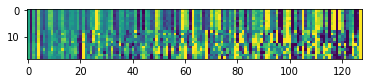

In [234]:
plt.imshow(X_train[0].reshape((19, 128)))

#### No max pooling, middle layer (1, 16, 16)

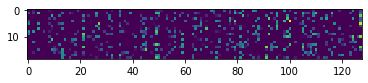

In [264]:
plt.imshow(decoded_imgs[0].reshape((19,128)))

In [114]:
input_shape

(32, 128, 1)

In [146]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,1), activation='relu', input_shape=input_shape, data_format='channels_last', padding='same'))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(64, (3,1), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(128, (3,1), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(256, (3,1), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same', name='pooling'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(256, (3,1), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2,2), padding='same', name='pooling'))

model.add(Conv2D(256, (3,1), activation='relu', padding='same'))

model.add(Flatten(name='flatten'))

model.add(Dense(30000, activation='relu'))

model.add(Dense(15000, activation='relu'))

model.add(Dense(7000, activation='relu'))

model.add(Dense(3500, activation='relu'))

model.add(Dense(1500, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(1500, activation='relu'))

model.add(Dense(3500, activation='relu'))

model.add(Dense(7000, activation='relu'))

model.add(Dense(15000, activation='relu'))

model.add(Dense(30000, activation='relu'))

#model.add(Dense(256, activation='relu'))

model.add(Dense(model.get_layer('flatten').output_shape[1], activation='relu'))
model.add(Reshape((model.get_layer('pooling').output_shape[1:])))

model.add(Conv2D(256, (3,1), activation='relu', padding='same'))

model.add(UpSampling2D(size=(2,2)))
#model.add(UpSampling2D(size=(1,1)))
model.add(Conv2D(256, (3,1), activation='relu',padding='same'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(128, (3,1), activation='relu',padding='same'))
model.add(Conv2D(64, (3,1), activation='relu',padding='same'))
#model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(32, (3,1), activation='relu',padding='same'))
#model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(1, (3,1), activation='sigmoid',padding='same'))
model.compile(loss='binary_crossentropy', optimizer='adadelta')

In [82]:
model.get_layer('flatten').output_shape[1]

4096

In [83]:
model.get_layer('pooling').output_shape[1:]

(2, 8, 256)

In [147]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_250 (Conv2D)          (None, 32, 128, 32)       128       
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 32, 128, 64)       6208      
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 32, 128, 128)      24704     
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 32, 128, 256)      98560     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 64, 256)       0         
_________________________________________________________________
conv2d_254 (Conv2D)          (None, 16, 64, 256)       196864    
_________________________________________________________________
pooling (MaxPooling2D)       (None, 8, 32, 256)        0         
__________

In [81]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(4,1), activation='relu', input_shape=input_shape, data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(64, (4,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(128, (3,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adadelta')

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 16, 128, 32)       160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 64, 32)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 64, 64)         8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 32, 64)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 32, 128)        24704     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 16, 128)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
__________